<a href="https://colab.research.google.com/github/olyavydrina/-/blob/main/%D0%92%D0%9A%D0%A0_%D1%80%D1%83%D1%81%D1%81%D0%BA%D0%B8%D0%B9_%D1%8F%D0%B7%D1%8B%D0%BA_NLTK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подключаем необходимые библиотеки

In [123]:
%tensorflow_version 2.x
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [124]:
!pip install pymorphy2[fast] 
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [125]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина новости
max_news_len = 300
# Количество классов новостей
nb_classes = 2

In [126]:
random_state = 42

In [127]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Загржаем и готовим набор данных

In [128]:
#!wget https://github.com/olyavydrina/-/blob/main/train2.xlsx?dl=1 -O train2.xlsx

In [129]:
#news = pd.read_excel('train2.xlsx')

In [130]:
news = pd.read_excel('/content/train2.xlsx')
news.head()

,class,title,text,link,language
0,0,Плотник ослеп и впал в кому из-за занозы,30-летний житель английского города Сент-Остел...,https://lenta.ru/news/2022/12/12/splinter/,rus
1,1,Зеленский оценил помощь США Украине,"Президент Украины Владимир Зеленский признал, ...",https://lenta.ru/news/2022/12/12/usa/,rus
2,0,Сбившего двух пешеходов и скрывшегося с места ...,"Полицейские задержали водителя иномарки, сбивш...",https://lenta.ru/news/2022/12/12/sbil_i_uyehal/,rus
3,0,Саакашвили ограничили в курении электронных си...,Лечащие врачи бывшего президента Грузии Михаил...,https://lenta.ru/news/2022/12/12/sigaretyfu/,rus
4,0,Россиянка упала под прибывающий поезд в метро ...,Пассажирка упала на пути под прибывающий поезд...,https://lenta.ru/news/2022/12/12/metro/,rus


In [131]:
def preprocess(text, stop_words, punctuation_marks, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)
    return preprocessed_text

In [132]:
punctuation_marks = ['!', ',', '(', ')', ':', '-', '?', '.', '..', '...', '«', '»', ';', '–', '--']
stop_words = stopwords.words("russian")
morph = pymorphy2.MorphAnalyzer()

In [133]:
news['Preprocessed_texts'] = news.apply(lambda row: preprocess(row['text'], punctuation_marks, stop_words, morph), axis=1)

Считаем частоту слов во всех новостях

In [134]:
words = Counter()

In [135]:
for txt in news['Preprocessed_texts']:
    words.update(txt)

Создаем словарь, упорядоченный по частоте

В словаре будем использовать 2 специальных кода:

Код заполнитель: 0
Неизвестное слово: 1
Нумерация слов в словаре начинается с 2.

In [136]:
# Словарь, отображающий слова в коды
word_to_index = dict()
# Словарь, отображающий коды в слова
index_to_word = dict()

Создаем словари

In [137]:
for i, word in enumerate(words.most_common(num_words - 2)):
    word_to_index[word[0]] = i + 2
    index_to_word[i + 2] = word[0]

Функция для преобразования списка слов в список кодов

In [138]:
def text_to_sequence(txt, word_to_index):
    seq = []
    for word in txt:
        index = word_to_index.get(word, 1) # 1 означает неизвестное слово
        # Неизвестные слова не добавляем в выходную последовательность
        if index != 1:
            seq.append(index)
    return seq


Преобразуем все тексты в последовательность кодов слов

In [139]:
news['Sequences'] = news.apply(lambda row: text_to_sequence(row['Preprocessed_texts'], word_to_index), axis=1)

In [140]:
news

,class,title,text,link,language,Preprocessed_texts,Sequences
0,0,Плотник ослеп и впал в кому из-за занозы,30-летний житель английского города Сент-Остел...,https://lenta.ru/news/2022/12/12/splinter/,rus,"[30-летний, житель, английский, город, сента-о...","[2358, 174, 2359, 101, 2360, 2361, 2362, 2363,..."
1,1,Зеленский оценил помощь США Украине,"Президент Украины Владимир Зеленский признал, ...",https://lenta.ru/news/2022/12/12/usa/,rus,"[президент, украина, владимир, зеленский, приз...","[17, 5, 85, 311, 532, 86, 264, 533, 93, 12, 16..."
2,0,Сбившего двух пешеходов и скрывшегося с места ...,"Полицейские задержали водителя иномарки, сбивш...",https://lenta.ru/news/2022/12/12/sbil_i_uyehal/,rus,"[полицейский, задержать, водитель, иномарка, с...","[110, 105, 195, 840, 665, 177, 61, 123, 436, 6..."
3,0,Саакашвили ограничили в курении электронных си...,Лечащие врачи бывшего президента Грузии Михаил...,https://lenta.ru/news/2022/12/12/sigaretyfu/,rus,"[лечить, врач, бывший, президент, грузия, миха...","[2425, 528, 196, 17, 667, 668, 1107, 3, 72, 24..."
4,0,Россиянка упала под прибывающий поезд в метро ...,Пассажирка упала на пути под прибывающий поезд...,https://lenta.ru/news/2022/12/12/metro/,rus,"[пассажирка, упасть, путь, прибывать, поезд, м...","[1572, 377, 669, 1111, 1112, 543, 1573, 1092, ..."
...,...,...,...,...,...,...,...
109,1,Шольц назвал три причины не поставлять немецки...,"МОСКВА, 17 дек — РИА Новости. Канцлер Германии...",https://ria.ru/20221217/tanki-1839465444.html,rus,"[москва, 17, дек, —, риа, новость, канцлер, ге...","[61, 234, 430, 2, 35, 30, 277, 21, 504, 352, 2..."
110,0,"Девушка получила переломы, упав в оркестровую ...","САРАТОВ, 17 дек - РИА Новости. Зрительница упа...",https://ria.ru/20221217/konservatoriya-1839463...,rus,"[саратов, 17, дек, риа, новость, зрительница, ...","[4879, 234, 430, 35, 30, 4880, 377, 560, 2349,..."
111,1,СМИ: США пытались помешать Украине совершить п...,"ВАШИНГТОН, 18 дек - РИА Новости. Газета New Yo...",https://ria.ru/20221218/gerasimov-1839474804.html,rus,"[вашингтон, 18, дек, риа, новость, газета, new...","[129, 469, 430, 35, 30, 420, 1437, 1438, 1439,..."
112,1,Минобороны подтвердило удары по объектам на Ук...,"МОСКВА, 18 дек — РИА Новости. Министерство обо...",https://ria.ru/20221218/udar-1839474444.html,rus,"[москва, 18, дек, —, риа, новость, министерств...","[61, 469, 430, 2, 35, 30, 294, 167, 4, 551, 99..."


## Выделяем данные для обучения и тестирования

In [141]:
train, test = train_test_split(news, test_size=0.2)

In [142]:
train

,class,title,text,link,language,Preprocessed_texts,Sequences
38,1,Пентагон «продолжит пересматривать» уровень пр...,"«Что я могу сообщить вам, так это то, что мы п...",https://russian.rt.com/world/news/1085389-ssha...,rus,"[мочь, сообщить, это, продолжить, пересматрива...","[31, 16, 11, 212, 1285, 454, 254, 591, 9, 2, 6..."
5,1,В Госдуме назвали условия вхождения Сербии в с...,Первый зампредседателя комитета Госдумы по меж...,https://lenta.ru/news/2022/12/12/serbia/,rus,"[первый, зампредседателя, комитет, госдума, ме...","[36, 2449, 225, 1581, 140, 45, 850, 1117, 380,..."
94,1,Сборная Хорватии стала бронзовым призером чемп...,Сборная Хорватии по футболу обыграла команду М...,https://lenta.ru/news/2022/12/17/croatiamorocco/,rus,"[сборная, хорватия, футбол, обыграть, команда,...","[216, 624, 734, 1471, 109, 1031, 24, 3949, 395..."
103,0,В Татарстане выявили 112 случаев коронавируса ...,Об этом сообщает «Реальное время» со ссылкой н...,https://russian.rt.com/russia/news/1087544-reg...,rus,"[сообщать, реальный, время, ссылка, региональн...","[44, 974, 26, 104, 2036, 4660, 784, 75, 4661, ..."
100,1,«Формализация антироссийских настроений»: поче...,Канада решила восстановить санкции против турб...,https://russian.rt.com/world/article/1086675-s...,rus,"[канада, решить, восстановить, санкция, против...","[134, 193, 657, 69, 59, 308, 20, 2258, 1070, 4..."
...,...,...,...,...,...,...,...
71,0,Путин поручил правительству увеличить зарплаты...,Президент Владимир Путин поручил кабмину увели...,https://ria.ru/20221212/zarplaty-1838178927.html,rus,"[президент, владимир, путин, поручить, кабмин,...","[17, 85, 58, 574, 874, 312, 75, 334, 6, 395, 1..."
10,0,Путин поручил кабмину увеличить зарплаты бюдже...,Президент России Владимир Путин поручил кабмин...,https://lenta.ru/news/2022/12/12/uvelicheniee/,rus,"[президент, россия, владимир, путин, поручить,...","[17, 4, 85, 58, 574, 874, 312, 395, 1165, 575,..."
21,0,Кадыров отреагировал на доклад о наступлении п...,Глава Чечни Рамзан Кадыров в своем Telegram-ка...,https://lenta.ru/news/2022/12/12/kadyrov/,rus,"[глава, чечня, рамзан, кадыров, свой, telegram...","[18, 2676, 1707, 1215, 15, 558, 2677, 1168, 12..."
27,0,Россиянам перечислили признаки перелома из-за ...,Отек и отсутствие подвижности конечности являю...,https://lenta.ru/news/2022/12/12/fracture/,rus,"[отечь, отсутствие, подвижность, конечность, я...","[1248, 729, 1758, 929, 96, 1759, 609, 930, 279..."


In [143]:
test

,class,title,text,link,language,Preprocessed_texts,Sequences
78,0,"В Москве полиция задержала водителя иномарки, ...","Полицейские задержали водителя иномарки, сбивш...",https://ria.ru/20221212/voditel-1838199698.html,rus,"[полицейский, задержать, водитель, иномарка, с...","[110, 105, 195, 840, 665, 123, 436, 1969, 94, ..."
106,0,Мэрия Москвы: заболеваемость ОРВИ не помешала ...,Медицинская сестра в инфекционном отделении дл...,https://ria.ru/20221218/koronavirus-1839476045...,rus,"[медицинский, сестра, инфекционный, отделение,...","[1300, 2191, 4802, 1994, 830, 2319, 61, 469, 4..."
102,1,Обмен голами в дебюте и шедевр Оршича: Хорвати...,Проведение матчей за третье место на чемпионат...,https://russian.rt.com/sport/article/1087519-h...,rus,"[проведение, матч, третий, место, чемпионат, м...","[326, 215, 189, 94, 257, 49, 1090, 4509, 806, ..."
17,1,США захотели увеличить число своих военных на ...,США планируют увеличить численность своих воен...,https://lenta.ru/news/2022/12/12/ukr/,rus,"[сша, планировать, увеличить, численность, сво...","[12, 143, 312, 374, 15, 19, 5, 313, 154, 194, ..."
50,1,"Эрдоган заявил, что на юго-востоке Турции обна...",«Стоимость запасов составляет примерно $12 млр...,https://russian.rt.com/world/news/1085346-erdo...,rus,"[стоимость, запас, составлять, примерно, $, 12...","[755, 476, 1310, 616, 756, 399, 302, 2, 252, 1..."
11,1,Байден ответил на сообщения об отправке америк...,Президент США Джо Байден опроверг отправку аме...,https://lenta.ru/news/2022/12/12/neotpravlyaut/,rus,"[президент, сша, джо, байден, опровергнуть, от...","[17, 12, 398, 184, 2575, 1655, 42, 19, 5, 273,..."
63,1,Шольц выступил за сотрудничество с Россией пос...,кономическое сотрудничество с Россией должно с...,https://ria.ru/20221212/sholts-1838202760.html,rus,"[кономический, сотрудничество, россия, должный...","[3089, 413, 4, 43, 24, 387, 739, 55, 5, 10, 27..."
82,0,"Ученые придумали, как достичь эффекта невидимости",Ученые ТПУ совместно с зарубежными коллегами р...,https://ria.ru/20221212/tpu-1837427358.html,rus,"[учёный, тпу, совместно, зарубежный, коллега, ...","[787, 1392, 632, 3332, 1131, 637, 3333, 1879, ..."
92,1,Посол покинул съезд партии в Сербии после виде...,Посол России в Сербии Александр Боцан-Харченко...,https://lenta.ru/news/2022/12/18/psll/,rus,"[посол, россия, сербия, александр, боцан-харче...","[644, 4, 28, 97, 1050, 425, 1051, 1349, 130, 3..."
9,0,Сбер предложил бизнесу купить золото в цифрово...,Сбер начинает выпуск цифровых финансовых актив...,https://lenta.ru/news/2022/12/12/zlt/,rus,"[сбер, начинать, выпуск, цифровой, финансовый,...","[2531, 1640, 865, 570, 452, 330, 391, 331, 865..."


## Разделяем метки классов и данные для обучения

Данные для обучения

In [144]:
x_train = train['Sequences']
y_train = train['class']

In [145]:
x_train

38     [31, 16, 11, 212, 1285, 454, 254, 591, 9, 2, 6...
5      [36, 2449, 225, 1581, 140, 45, 850, 1117, 380,...
94     [216, 624, 734, 1471, 109, 1031, 24, 3949, 395...
103    [44, 974, 26, 104, 2036, 4660, 784, 75, 4661, ...
100    [134, 193, 657, 69, 59, 308, 20, 2258, 1070, 4...
                             ...                        
71     [17, 85, 58, 574, 874, 312, 75, 334, 6, 395, 1...
10     [17, 4, 85, 58, 574, 874, 312, 395, 1165, 575,...
21     [18, 2676, 1707, 1215, 15, 558, 2677, 1168, 12...
27     [1248, 729, 1758, 929, 96, 1759, 609, 930, 279...
49     [197, 40, 80, 1307, 49, 312, 577, 6, 1832, 302...
Name: Sequences, Length: 91, dtype: object

!!! Ограничиваем длину новостных сообщений

In [146]:
x_train = pad_sequences(x_train, maxlen=max_news_len)

In [147]:
x_train

array([[   0,    0,    0, ...,  107, 1289,   73],
       [   0,    0,    0, ...,  231, 2470,   87],
       [   0,    0,    0, ...,   49,    2, 3974],
       ...,
       [   0,    0,    0, ...,   53,  907,  165],
       [   0,    0,    0, ..., 1769,   62, 2839],
       [   0,    0,    0, ..., 2990,  304,   86]], dtype=int32)

In [148]:
y_train

38     1
5      1
94     1
103    0
100    1
      ..
71     0
10     0
21     0
27     0
49     1
Name: class, Length: 91, dtype: int64

!!! Выделяем правильные ответы (преобразуем в формат one hot encoding)

In [149]:
y_train = utils.to_categorical(y_train, nb_classes)

In [150]:
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

Данные для тестирования

In [151]:
x_test = test['Sequences']
y_test = test['class']

In [152]:
x_test

78     [110, 105, 195, 840, 665, 123, 436, 1969, 94, ...
106    [1300, 2191, 4802, 1994, 830, 2319, 61, 469, 4...
102    [326, 215, 189, 94, 257, 49, 1090, 4509, 806, ...
17     [12, 143, 312, 374, 15, 19, 5, 313, 154, 194, ...
50     [755, 476, 1310, 616, 756, 399, 302, 2, 252, 1...
11     [17, 12, 398, 184, 2575, 1655, 42, 19, 5, 273,...
63     [3089, 413, 4, 43, 24, 387, 739, 55, 5, 10, 27...
82     [787, 1392, 632, 3332, 1131, 637, 3333, 1879, ...
92     [644, 4, 28, 97, 1050, 425, 1051, 1349, 130, 3...
9      [2531, 1640, 865, 570, 452, 330, 391, 331, 865...
53     [1317, 1167, 459, 458, 460, 316, 58, 10, 696, ...
47     [1825, 402, 473, 12, 74, 439, 25, 591, 19, 297...
110    [4879, 234, 430, 35, 30, 4880, 377, 560, 2349,...
61     [9, 1869, 451, 62, 80, 99, 1319, 767, 1870, 24...
67     [740, 174, 260, 1913, 102, 776, 1358, 34, 207,...
54     [1318, 892, 166, 69, 59, 4, 617, 346, 127, 401...
15     [61, 195, 840, 665, 123, 436, 471, 1185, 1186,...
89     [3526, 703, 49, 3527, 35

Ограничиваем длину новостных сообщений

In [153]:
x_test = pad_sequences(x_test, maxlen=max_news_len)

In [154]:
x_test

array([[   0,    0,    0, ...,  192,  317, 1558],
       [   0,    0,    0, ..., 1886, 1074,  825],
       [1018, 1478, 1522, ...,   68, 4659,  486],
       ...,
       [   0,    0,    0, ...,  125,  375, 2424],
       [   0,    0,    0, ..., 3494,  181,  132],
       [   0,    0,    0, ...,  685,  275,  159]], dtype=int32)

In [155]:
y_test

78     0
106    0
102    1
17     1
50     1
11     1
63     1
82     0
92     1
9      0
53     0
47     1
110    0
61     1
67     1
54     1
15     0
89     1
112    1
74     0
2      0
87     1
13     0
Name: class, dtype: int64

Выделяем правильные ответы (преобразуем в формат one hot encoding)

In [156]:
y_test = utils.to_categorical(y_test, nb_classes)

In [157]:
y_test

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

## Создаем нейронную сеть с долгой краткосрочной памятью - LSTM

In [158]:
model_lstm = Sequential()
# 1-й слой - Embedding - создает плотные векторные представления слов, длина вектора - 128
model_lstm.add(Embedding(num_words, 128, input_length=max_news_len))
# 2-й и 3-й слои - LSTM - в пих по 64 и 32 ячейки
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
# 4-й слой - Выходной полносвязный слой, 2 нейрона (по количеству классов)
model_lstm.add(Dense(2, activation='sigmoid'))

создаем последовательную модель (определяем оптимизатор, функцию ошибки)

In [159]:
model_lstm.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

Выводим информацию о сети

In [160]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 128)          1280000   
                                                                 
 lstm_2 (LSTM)               (None, 300, 64)           49408     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,341,890
Trainable params: 1,341,890
Non-trainable params: 0
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [161]:
model_lstm_save_path = '/content/best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

Обучаем нейронную сеть

In [178]:
history_lstm = model_lstm.fit(x_train,
                              y_train, 
                              epochs=5,
                              batch_size=32,
                              validation_split=0.5,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 0.3830 - accuracy: 0.8750
Epoch 1: val_accuracy improved from 0.52439 to 0.84783, saving model to /content/best_model_lstm.h5
2/2 [==============================] - 0s 159ms/step - loss: 0.3143 - accuracy: 0.9111 - val_loss: 0.4301 - val_accuracy: 0.8478
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 0.2264 - accuracy: 0.9688
Epoch 2: val_accuracy did not improve from 0.84783
2/2 [==============================] - 0s 79ms/step - loss: 0.2115 - accuracy: 0.9778 - val_loss: 0.3824 - val_accuracy: 0.8478
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 0.1742 - accuracy: 1.0000
Epoch 3: val_accuracy improved from 0.84783 to 0.89130, saving model to /content/best_model_lstm.h5
2/2 [==============================] - 0s 130ms/step - loss: 0.1597 - accuracy: 1.0000 - val_loss: 0.3371 - val_accuracy: 0.8913
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 0.1329 - accuracy: 1.0000

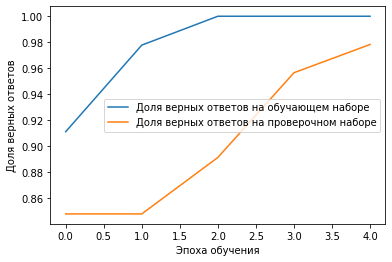

In [179]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Оцениваем качество работы сети на тестовом наборе данных

### Сеть LSTM

Загружаем модель с лучшей долей правильных ответов на проверочном наборе данных

In [180]:
model_lstm.load_weights(model_lstm_save_path)

Оцениваем качество работы сети на наборе данных для тестирования

In [181]:
scores = model_lstm.evaluate(x_test, y_test, verbose=1)

1/1 [==============================] - 0s 32ms/step - loss: 0.2866 - accuracy: 0.8696


In [182]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 86.9565


**Оцениваем качество работы сети на новых данных**

In [168]:
text = ''' Удар украинских войск по больнице в Новоайдаре в Луганской Народной Республике является нарушением Устава ООН, заявил РИА Новости генеральный координатор сирийского центра помощи жертвам насилия и терроризма Тамер Яги. Украинские войска 28 января нанесли удар по больнице в Новоайдаре (ЛНР) из американских реактивных систем залпового огня HIMARS. Погибли 14 человек, еще 24 получили ранения, сообщило Минобороны РФ. В ведомстве отметили, что удар по гражданскому объекту является военным преступлением.'''

Преобразуем новости в числовое представление

In [169]:
text1 = preprocess(text, stop_words, punctuation_marks, morph)

In [170]:
text1

['удар',
 'украинский',
 'войско',
 'больница',
 'новоайдар',
 'луганский',
 'народный',
 'республика',
 'являться',
 'нарушение',
 'устав',
 'оон',
 'заявить',
 'риа',
 'новость',
 'генеральный',
 'координатор',
 'сирийский',
 'центр',
 'помощь',
 'жертва',
 'насилие',
 'терроризм',
 'тамер',
 'яга',
 'украинский',
 'войско',
 '28',
 'январь',
 'нанести',
 'удар',
 'больница',
 'новоайдар',
 'лнр',
 'американский',
 'реактивный',
 'система',
 'залповый',
 'огонь',
 'himars',
 'погибнуть',
 '14',
 'человек',
 'ещё',
 '24',
 'получить',
 'ранение',
 'сообщить',
 'минобороны',
 'рф',
 'ведомство',
 'отметить',
 'удар',
 'гражданский',
 'объект',
 'являться',
 'военный',
 'преступление']

In [171]:
sequence = text_to_sequence(text1, word_to_index)

In [172]:
sequence

[253,
 34,
 207,
 530,
 232,
 96,
 444,
 132,
 10,
 35,
 30,
 918,
 3017,
 177,
 51,
 982,
 3146,
 34,
 207,
 4388,
 947,
 510,
 253,
 530,
 4425,
 42,
 4232,
 71,
 4233,
 856,
 2916,
 260,
 759,
 37,
 172,
 736,
 78,
 1299,
 16,
 1198,
 38,
 95,
 57,
 253,
 799,
 217,
 96,
 19,
 1264]

In [173]:
print(text)
print(sequences)

 Удар украинских войск по больнице в Новоайдаре в Луганской Народной Республике является нарушением Устава ООН, заявил РИА Новости генеральный координатор сирийского центра помощи жертвам насилия и терроризма Тамер Яги. Украинские войска 28 января нанесли удар по больнице в Новоайдаре (ЛНР) из американских реактивных систем залпового огня HIMARS. Погибли 14 человек, еще 24 получили ранения, сообщило Минобороны РФ. В ведомстве отметили, что удар по гражданскому объекту является военным преступлением.
[253, 34, 207, 530, 232, 96, 444, 132, 10, 35, 30, 918, 3017, 177, 51, 982, 3146, 34, 207, 4388, 947, 510, 253, 530, 4425, 42, 4232, 71, 4233, 856, 2916, 260, 759, 37, 172, 736, 78, 1299, 16, 1198, 38, 95, 57, 253, 799, 217, 96, 19, 1264]


In [174]:
text2 = pad_sequences(sequences, maxlen=max_news_len)

ValueError: ignored

In [175]:
text2

[253,
 34,
 207,
 530,
 232,
 96,
 444,
 132,
 10,
 35,
 30,
 918,
 3017,
 177,
 51,
 982,
 3146,
 34,
 207,
 4388,
 947,
 510,
 253,
 530,
 4425,
 42,
 4232,
 71,
 4233,
 856,
 2916,
 260,
 759,
 37,
 172,
 736,
 78,
 1299,
 16,
 1198,
 38,
 95,
 57,
 253,
 799,
 217,
 96,
 19,
 1264]

Загружаем модель в память

In [176]:
model = load_model('best_model_lstm.h5')

Запускаем распознавание (применяем сеть для определения класса новости)

In [ ]:
prediction = model.predict(text2)

ValueError: ignored

Результаты распознавания

In [ ]:
prediction

NameError: ignored

In [ ]:
prediction = np.argmax(prediction)

NameError: ignored

In [ ]:
if prediction < 0.5:
    print('Не имеет международного значения')
else:
    print('Международная новость')

NameError: ignored